In [17]:
%matplotlib inline
import matplotlib.pylab as plt
import matplotlib.path as mplPath
import tables
import pandas as pd
import numpy as np

from food_feats import read_food_contour
from tierpsy_features.helper import DataPartition

#skeletons_file = '/Users/ajaver/Documents/GitHub/tierpsy-tracker/tests/data/_TEST/N2_worms10_CSCD563206_10_Set9_Pos4_Ch6_25072017_214236_skeletons.hdf5'
#skeletons_file = '/Users/ajaver/Documents/GitHub/tierpsy-tracker/tests/data/_TEST/N2_worms10_CSCD438313_10_Set12_Pos5_Ch4_25072017_223347_skeletons.hdf5'
skeletons_file = '/Users/ajaver/Documents/GitHub/tierpsy-tracker/tests/data/_TEST/MY23_worms5_food1-10_Set4_Pos5_Ch4_29062017_140148_skeletons.hdf5'
#skeletons_file = '/Volumes/behavgenom_archive$/Solveig/Results/Experiment8/170822_matdeve_exp8co3/170822_matdeve_exp8co3_12_Set0_Pos0_Ch1_22082017_140000_skeletons.hdf5'

features_file = skeletons_file.replace('_skeletons.hdf5', '_featuresN.hdf5')
food_cnt = read_food_contour(skeletons_file)

with pd.HDFStore(features_file, 'r') as fid:
    trajectories_data = fid['/trajectories_data']
    
trajectories_data = trajectories_data[trajectories_data['skeleton_id']>-1]
trajectories_data_g = trajectories_data.groupby('worm_index_joined')


In [22]:
worm_index = 3
worm_data = trajectories_data_g.get_group(worm_index)
skel_id = worm_data['skeleton_id'].values 
with tables.File(features_file, 'r') as fid:
    skeletons_o = fid.get_node('/coordinates/skeletons')[skel_id, :, :]

    

(2000.0, 16000.0, 2000.0, 16000.0)

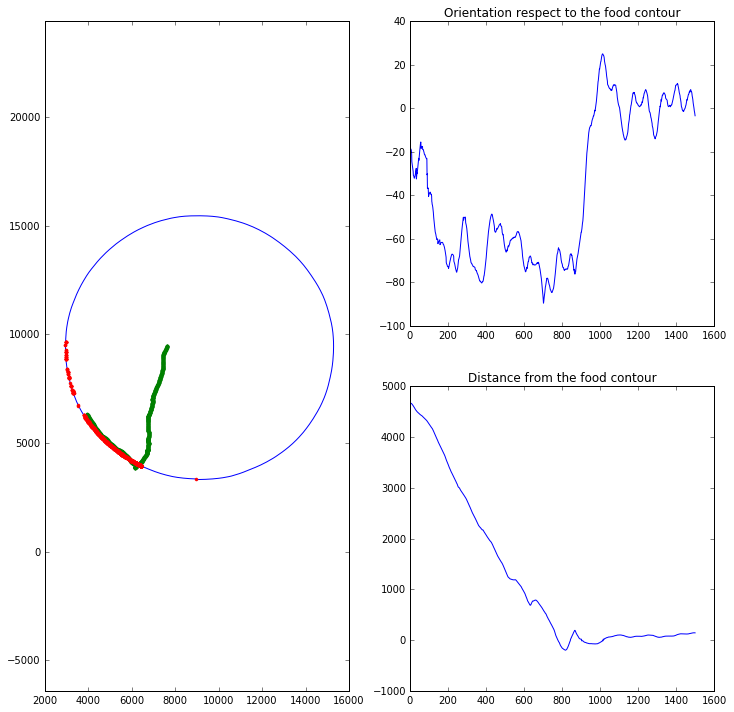

In [77]:
from tierpsy_features.velocities import _h_segment_position

skeletons = skeletons_o[3000:4500]

get_unit_vec = lambda x : x/np.linalg.norm(x, axis=1)[:, np.newaxis]

worm_coords, orientation_v = _h_segment_position(skeletons, partition = 'body')

rr = np.linalg.norm(worm_coords[:, None, :] - food_cnt[None, ...], axis=2)
cnt_ind = np.argmin(rr, axis=1)
dist_from_cnt = np.array([x[i] for i,x in zip(cnt_ind, rr)])
bbPath = mplPath.Path(food_cnt)
outside = ~bbPath.contains_points(worm_coords)
dist_from_cnt[outside] = -dist_from_cnt[outside]

worm_u = get_unit_vec(orientation_v)



top = cnt_ind+1
top[top>=food_cnt.shape[0]] -= food_cnt.shape[0] #fix any overflow index
bot = cnt_ind-1 #it is not necessary to correct because we can use negative indexing
food_u =  get_unit_vec(food_cnt[top]-food_cnt[bot])

#I am using the normal
R = np.array([[0,1], [-1, 0]])
food_u = (np.dot(R, food_u.T)).T


dot_prod = np.sum(food_u*worm_u, axis=1) 

orientation_food_cnt = 90-np.arccos(dot_prod)*180/np.pi

plt.figure(figsize=(12,12))

plt.subplot(2,2,2)
plt.plot(orientation_food_cnt)
plt.title('Orientation respect to the food contour')

plt.subplot(2,2,4)
plt.plot(dist_from_cnt)
plt.title('Distance from the food contour')

plt.subplot(1,2,1)
plt.plot(food_cnt[:,0], food_cnt[:,1])
plt.plot(worm_coords[:,0], worm_coords[:,1], '.')
plt.plot(food_cnt[cnt_ind,0], food_cnt[cnt_ind,1], 'r.')
plt.axis('equal')

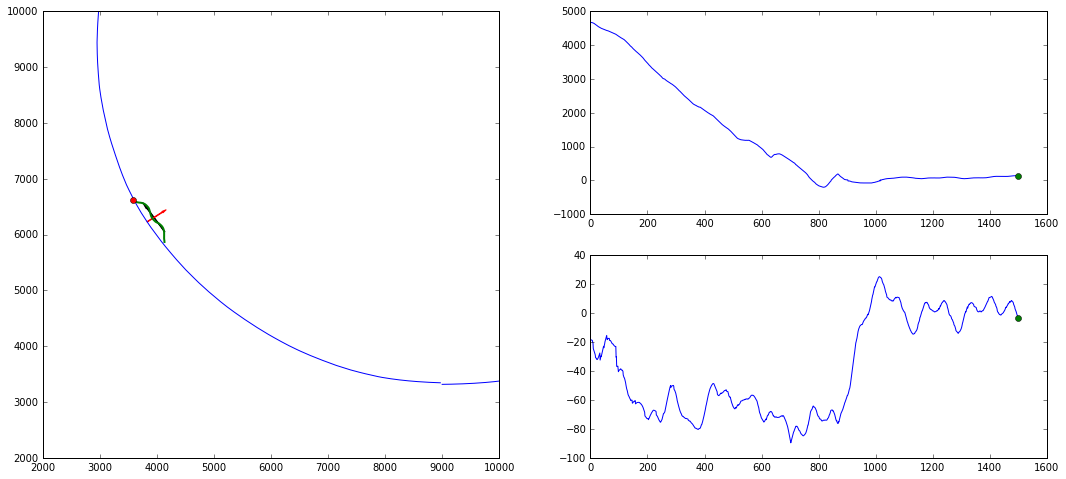

In [78]:
import matplotlib.pylab as plt
from matplotlib import animation, patches
from IPython.display import HTML

def _h_ax_range(skel_a):
    x_range = [np.nanmin(skel_a[...,0]), np.nanmax(skel_a[...,0])]
    y_range = [np.nanmin(skel_a[...,1]), np.nanmax(skel_a[...,1])]
    
    dx, dy = np.diff(x_range), np.diff(y_range)
    if dx > dy:
        y_range[1] = y_range[0] + dx
    else:
        x_range[1] = x_range[0] + dy
    
    return (x_range, y_range)

d_r = (0, 1500)

ini_t = d_r[0]
fin_t = d_r[1]

skel_a = skeletons[ini_t:fin_t]
arrow_size = orientation_v[ini_t:fin_t]
ini_arrow = worm_coords[ini_t:fin_t] - arrow_size/2

ini_arrow_f = food_cnt[cnt_ind[ini_t:fin_t]]
arrow_size_f = food_u[ini_t:fin_t]*400


plot_1 = dist_from_cnt[ini_t:fin_t]
plot_2 = orientation_food_cnt[ini_t:fin_t]

x_range, y_range = _h_ax_range(food_cnt)
fig = plt.figure(figsize = (18, 8))
ax = plt.subplot(1,2,1)
#ax.set_xlim(*x_range)
#ax.set_ylim(*y_range)


ax.plot(food_cnt[:,0], food_cnt[:,1])
line, = ax.plot([], [], lw=2)
head_p, = ax.plot([], [], 'o')
orient_arrow = patches.Arrow(*ini_arrow[0], *arrow_size[0], fc='k', ec='k')
orient_food = patches.Arrow(*ini_arrow_f[0], *arrow_size_f[0], fc='b', ec='b')


#food_p, = ax.plot([], '.') 

ax.set_xlim(2000,10000)
ax.set_ylim(2000,10000)
#ax.axis('equal')

ax_speed = plt.subplot(2,2,2)
ax_ang_speed = plt.subplot(2,2,4)
ax_speed.plot(plot_1)
ax_ang_speed.plot(plot_2)
sub_p1, = ax_speed.plot([], 'o') 
sub_p2, = ax_ang_speed.plot([],  'o') 

def _animate(i):
    global orient_arrow
    global orient_food

    x = skel_a[i, :, 0]
    y = skel_a[i, :, 1]
    line.set_data(x, y)
    head_p.set_data(x[0], y[0])
    if ax.patches:
        ax.patches.remove(orient_arrow) 
        ax.patches.remove(orient_food) 
        
    orient_arrow = patches.Arrow(*ini_arrow[i], *arrow_size[i], width=50, fc='k', ec='k')
    ax.add_patch(orient_arrow)
    
    
    
    orient_food = patches.Arrow(*ini_arrow_f[i], *arrow_size_f[i], width=50, fc='r', ec='r')
    ax.add_patch(orient_food)

    sub_p1.set_data(i, plot_1[i])
    sub_p2.set_data(i, plot_2[i])
    return (line, head_p, orient_arrow, sub_p1, sub_p2)

# call the animator. blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, _animate,
                               frames=skel_a.shape[0], interval=20, blit=True);


HTML(anim.to_html5_video())
